**Importing the required modules**

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re #regular expression
%matplotlib inline
#nlp module
!pip install nltk 
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer

!pip install wordcloud
from wordcloud import WordCloud

!pip install tweet-preprocessor
import preprocessor as p

from gensim.models import KeyedVectors #word2vec

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Loading the datasets, reading the csv files into dataframes**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
#Dataset containing the random tweets
dataset = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding=encoding, names=col_names)

In [ ]:
df = dataset.copy().sample(8000, random_state=42)
df["label"] = 0
df = df[['text', 'label']]
df.dropna(inplace=True)
df.head()

,text,label
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
750,"@misstoriblack cool , i have no tweet apps fo...",0
766711,@TiannaChaos i know just family drama. its la...,0
285055,School email won't open and I have geography ...,0
705995,upper airways problem,0


In [ ]:
col_names = ['id', 'text']
#Processed dataset containing depressive tweets scrapped from twitter using twint
df2 = pd.read_csv('/content/drive/MyDrive/depressive_tweets_processed.csv', sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2345 non-null   object
 1   text    2313 non-null   object
dtypes: object(2)
memory usage: 36.8+ KB


In [ ]:
df2['label'] = 1
df2 = df2[['text', 'label']]

In [ ]:
df = pd.concat([df,df2]) # merge the dataset on normal tweets and depressive tweets
df = df.sample(frac=1)  # shuffle the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10345 entries, 1454 to 1283461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10313 non-null  object
 1   label   10345 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 242.5+ KB


In [ ]:
#file that contains most common english words and their contractions
contractions = pd.read_json('/content/drive/MyDrive/contractions.json', typ='series')
contractions = contractions.to_dict()

Replacing all the words with their contractions

In [ ]:
c_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return contractions[match.group(0)]
    return c_re.sub(replace, text)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#Cleaning the tweets and processing them to remove punctuations,images,stop words,hastags and mentions
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets
X = clean_tweets([tweet for tweet in df['text']])

In [ ]:
#Indicates the words used most in the depressive tweets with the size indicating their frequency and importance
depressive_tweets = [clean_tweets([t for t in df2['text']])]
depressive_words = ' '.join(list(map(str, depressive_tweets)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)

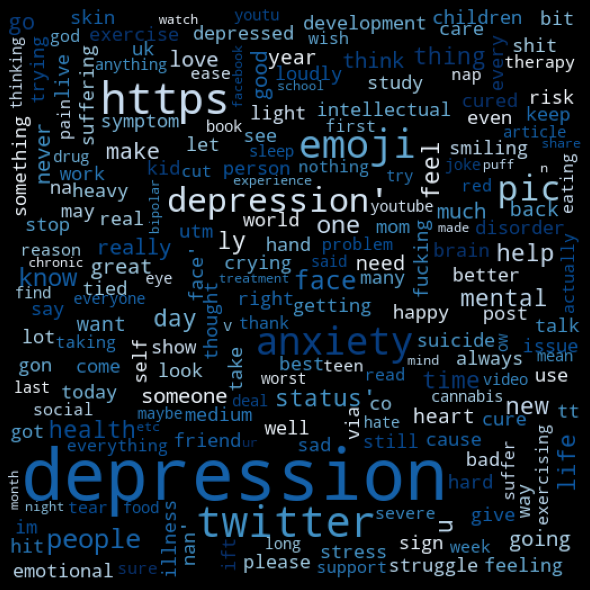

In [ ]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
MAX_NUM_WORDS = 10000
tokenizer= Tokenizer(num_words=MAX_NUM_WORDS) #breaks the raw text into tokens to understand the context
tokenizer.fit_on_texts(X)

In [ ]:
word_vector = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size   # num of unique tokens

20670

In [ ]:
MAX_SEQ_LENGTH = 140
input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)

TF-IDF: Calculates the term frequency of each word to determine how relevant they are. Done as a part of feature extraction

In [ ]:
corpus = df['text'].values.astype('U')
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS) 
tdidf_tensor = tfidf.fit_transform(corpus)

**MODELS**

SVC:Support Vector Classifier is used as our baseline model to map data points to a high-dimensional space and then find the optimal hyperplane that divides the data into two classes.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tdidf_tensor, df['label'].values, test_size=0.3)
baseline_model = SVC()
baseline_model.fit(x_train, y_train)

SVC()

In [ ]:
predictions = baseline_model.predict(x_test)
accuracy_score(y_test, predictions)

0.9961340206185567

In [ ]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.99544   0.99958   0.99751      2402
           1    0.99855   0.98433   0.99139       702

    accuracy                        0.99613      3104
   macro avg    0.99700   0.99196   0.99445      3104
weighted avg    0.99614   0.99613   0.99612      3104



Naive Bayes Classifier

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, df.label, test_size=0.3, random_state = 42)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [ ]:
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9107603092783505
              precision    recall  f1-score   support

           0    0.89792   0.99917   0.94585      2421
           1    0.99512   0.59736   0.74657       683

    accuracy                        0.91076      3104
   macro avg    0.94652   0.79827   0.84621      3104
weighted avg    0.91931   0.91076   0.90200      3104



Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
y_pred = sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9858247422680413
              precision    recall  f1-score   support

           0    0.98254   0.99959   0.99099      2421
           1    0.99844   0.93704   0.96677       683

    accuracy                        0.98582      3104
   macro avg    0.99049   0.96831   0.97888      3104
weighted avg    0.98604   0.98582   0.98566      3104



Comparison with Logistic Regression Model : Used by most binary classification models

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [ ]:
y_pred = logreg.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.96875
              precision    recall  f1-score   support

           0    0.99196   0.96778   0.97972      2421
           1    0.89488   0.97218   0.93193       683

    accuracy                        0.96875      3104
   macro avg    0.94342   0.96998   0.95582      3104
weighted avg    0.97060   0.96875   0.96920      3104



Word2Vec 

In [ ]:
EMBEDDING_FILE ='/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

In [ ]:
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NUM_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

**LSTM**
Different models under LSTM using different optimizers and activation functions are used and compared

In [ ]:
inp = Input(shape=(MAX_SEQ_LENGTH,))
x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_tensor, df['label'].values, test_size=0.3)
model.fit(x_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
453/453 [==============================] - 246s 543ms/step - loss: 0.0252 - accuracy: 0.9935
Epoch 2/10
453/453 [==============================] - 220s 486ms/step - loss: 0.0099 - accuracy: 0.9968
Epoch 3/10
453/453 [==============================] - 217s 478ms/step - loss: 0.0062 - accuracy: 0.9982
Epoch 4/10
453/453 [==============================] - 217s 479ms/step - loss: 0.0039 - accuracy: 0.9990
Epoch 5/10
453/453 [==============================] - 219s 484ms/step - loss: 0.0027 - accuracy: 0.9994
Epoch 6/10
453/453 [==============================] - 217s 479ms/step - loss: 0.0023 - accuracy: 0.9992
Epoch 7/10
453/453 [==============================] - 218s 481ms/step - loss: 0.0059 - accuracy: 0.9983
Epoch 8/10
453/453 [==============================] - 218s 480ms/step - loss: 0.0026 - accuracy: 0.9992
Epoch 9/10
453/453 [==============================] - 217s 480ms/step - loss: 0.0021 - accuracy: 0.9994
Epoch 10/10
453/453 [==============================] - 217s 479m

In [ ]:
preds = model.predict(x_test)
preds  = np.round(preds.flatten())
print(classification_report(y_test, preds, digits=5))

97/97 [==============================] - 9s 83ms/step
              precision    recall  f1-score   support

           0    0.99791   0.99708   0.99750      2397
           1    0.99013   0.99293   0.99153       707

    accuracy                        0.99613      3104
   macro avg    0.99402   0.99500   0.99451      3104
weighted avg    0.99614   0.99613   0.99614      3104



In [ ]:
inp = Input(shape=(MAX_SEQ_LENGTH,))
x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="tanh")(x)

Since our Model1 of LSTM gave us an accuracy of 99.6% we'll interrupt every other model that's giving a much lesser value

In [ ]:
model2 = Model(inputs=inp, outputs=x)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_tensor, df['label'].values, test_size=0.3)
model2.fit(x_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
453/453 [==============================] - 243s 518ms/step - loss: 3.5021 - accuracy: 0.7730
Epoch 2/10
453/453 [==============================] - 224s 494ms/step - loss: 3.5021 - accuracy: 0.7730
Epoch 3/10
453/453 [==============================] - 222s 491ms/step - loss: 3.5021 - accuracy: 0.7730
Epoch 4/10
330/453 [====================>.........] - ETA: 1:02 - loss: 3.5174 - accuracy: 0.7720

KeyboardInterrupt: ignored

In [ ]:
inp = Input(shape=(MAX_SEQ_LENGTH,))
x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="softmax")(x)

In [ ]:
model2 = Model(inputs=inp, outputs=x)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_tensor, df['label'].values, test_size=0.3)
model2.fit(x_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
453/453 [==============================] - 228s 492ms/step - loss: 0.0723 - accuracy: 0.2223
Epoch 2/10
 89/453 [====>.........................] - ETA: 2:58 - loss: 0.0091 - accuracy: 0.2381

KeyboardInterrupt: ignored

In [ ]:
inp = Input(shape=(MAX_SEQ_LENGTH,))
x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)

In [ ]:
model3 = Model(inputs=inp, outputs=x)
model3.compile(loss='hinge', optimizer='adam', metrics=['accuracy'])
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_tensor, df['label'].values, test_size=0.3)
model3.fit(x_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
453/453 [==============================] - 229s 496ms/step - loss: 1.0060 - accuracy: 0.7716
Epoch 2/10
453/453 [==============================] - 223s 491ms/step - loss: 1.0000 - accuracy: 0.7721
Epoch 3/10
453/453 [==============================] - 221s 487ms/step - loss: 1.0000 - accuracy: 0.7721
Epoch 4/10
453/453 [==============================] - 220s 485ms/step - loss: 1.0000 - accuracy: 0.7721
Epoch 5/10
453/453 [==============================] - 220s 487ms/step - loss: 1.0000 - accuracy: 0.7721
Epoch 6/10
453/453 [==============================] - 227s 501ms/step - loss: 1.0000 - accuracy: 0.7721
Epoch 7/10
453/453 [==============================] - 223s 493ms/step - loss: 1.0000 - accuracy: 0.7721
Epoch 8/10
453/453 [==============================] - 222s 489ms/step - loss: 1.0000 - accuracy: 0.7721
Epoch 9/10
453/453 [==============================] - 221s 488ms/step - loss: 1.0000 - accuracy: 0.7721
Epoch 10/10
453/453 [==============================] - 222s 489m

In [ ]:
model4 = Model(inputs=inp, outputs=x)
model4.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_tensor, df['label'].values, test_size=0.3)
model4.fit(x_train, y_train, batch_size=16, epochs=10)